## Librerías

In [48]:
from pathlib import Path
import pandas as pd
import numpy as np
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

##  1. Cargar datos y definir ruta

In [49]:
# -----------------------------
# 1. Cargar datos y definir ruta
# -----------------------------

s2016 = pd.read_excel(BASE_PATH / "BASE_SEGUIMIENTO_2016_reducida.xlsx")
s2019 = pd.read_excel(BASE_PATH / "BASE_SEGUIMIENTO_2019_reducida.xlsx")
s2022 = pd.read_excel(BASE_PATH / "BASE_SEGUIMIENTO_2022_reducida.xlsx")

## 2. Disciplinas alta demanda

In [50]:
disciplinas_alta_demanda = set([
    unidecode(d).strip().lower() for d in [
        "Informática Generalista", "Contaduría", "Ingeniería Industrial", "Estadística",
        "Desarrollo de Software", "Finanzas", "Diseño Gráfico", "Inglés",
        "Ingeniería Mecánica", "Ingeniería Electrónica", "Química", "Ingeniería de los Materiales",
        "Microbiología", "Administración", "Ingeniería Química", "Ecología", "Comercio Internacional",
        "Ciencias de la Computación", "Ingeniería del Software", "Ingeniería de Materiales"
    ]
])

## 3. Diccionario de mapeo

In [51]:
MAPEO_EQUIVALENCIAS = {
    "anio_graduacion": ["Año_graduacion", "AÑO"],
    "sexo": ["M2", "N2","N1"],
    "grado_academico": ["Grado", "GRADO"],
    "continua_estudios": ["Cont_estudios"],
    "relacion_estudios": ["A4", "B4"],
    "ingles": ["A5_1", "B5_1"],
    "frances": ["A5_2", "B5_2"],
    "portugues": ["A5_3", "B5_3"],
    "aleman": ["A5_4", "B5_4"],
    "italiano": ["A5_5", "B5_5"],
    "chino": ["A5_6", "B5_6"],
    "solo_espanol": ["A5_7", "B5_7"],  
    "satisf_u": ["A7", "A1","A2"],  
    "satisf_carrera": ["A11", "A6","A3"],
    "trabaja_durante_carr": ["B21", "C41","C5"],
    "trabaja_graduarse": ["C1", "D1"],
    "busc_trab_relac": ["C2", "D2"],
    "tiem_1trab_relac": ["C3", "D3"],   
    "trab_actual": ["D111", "E1"],
    "cant_empleos": ["D41", "E41"],
    "tipo_contrat": ["F1", "G51", "G4"],
    "puesto_trabajo": ["F7", "G13", "G10"],
    "carrera_graduo": ["F8_1", "G14_1", "G11_1"],
    "disponibilidad_horaria": ["F8_2", "G14_2", "G11_2"],
    "disponibilidad_residir": ["F8_3", "G14_3", "G11_3"],
    "espiritu_emprendedor": ["F8_4", "G14_4", "G11_4"],
    "experiencia_laboral": ["F8_5", "G14_5", "G11_5"],
    "grado_acad_influye": ["F8_6", "G14_6", "G11_6"],
    "lugar_residencia": ["F8_7", "G14_7", "G11_7"],
    "poseer_2do_idioma": ["F8_8", "G14_8", "G11_8"],
    "recomendacion_persona": ["F8_9", "G14_9", "G11_9"],   
    "universidad_graduo": ["F8_10", "G14_10", "G11_10"], 
    "ya_conocian": ["F8_11", "G14_11", "G11_11"],
    "pruebas_seleccion": ["F8_12", "G14_12", "G11_12"],
    "grado_relacion": ["G1", "H1"],
    "satisf_trab_actual": ["G5", "H5","H3"],
    "conoc_teoricos_1": ["H8_1_0", "G6a_1_0","H5_1_1"],
    "conoc_teoricos_2": ["G6a_1_1", "H8_1_1","H5_1_2"],
    "conoc_practicos_1": ["G6a_2_0", "H8_2_0","H5_2_1"],
    "conoc_practicos_2": ["G6a_2_1", "H8_2_1","H5_2_2"],
    "aprender_act_1": ["G6a_3_0", "H8_3_0","H5_3_1"],
    "aprender_act_2": ["G6a_3_1", "H8_3_1","H5_3_2"],
    "trabajo_equipo_1": ["G6a_4_0", "H8_4_0","H5_4_1"],
    "trabajo_equipo_2": ["G6a_4_1", "H8_4_1","H5_4_2"], 
    "prog_infor_bas_1": ["G6a_5_0", "H8_5_0","H5_5_1"], 
    "prog_infor_bas_2": ["G6a_5_1", "H8_5_1","H5_5_2"], 
    "redact_doc_inf_1": ["G6a_6_0", "H8_6_0","H5_6_1"], 
    "redact_doc_inf_2": ["G6a_6_1", "H8_6_1","H5_6_2"], 
    "expresar_verbal_1": ["G6a_7_0", "H8_7_0","H5_7_1"], 
    "expresar_verbal_2": ["G6a_7_1", "H8_7_1","H5_7_2"], 
    "hablar_publico_1": ["G6a_8_0", "H8_8_0","H5_8_1"],
    "hablar_publico_2": ["G6a_8_1", "H8_8_1","H5_8_2"],
    "tomar_decision_1": ["G6a_9_0", "H8_9_0","H5_9_1"],
    "tomar_decision_2": ["G6a_9_1", "H8_9_1","H5_9_2"],
    "manejo_ingles_1": ["G6a_10_0", "H8_10_0","H5_10_1"],
    "manejo_ingles_2": ["G6a_10_1", "H8_10_1","H5_10_2"],
    "investig_disc_1": ["G6a_11_0", "H8_11_0","H5_11_1"],
    "investig_disc_2": ["G6a_11_1", "H8_11_1","H5_11_2"],   
    "resolver_prob_1": ["G6a_12_0", "H8_12_0","H5_12_1"],
    "resolver_prob_2": ["G6a_12_1", "H8_12_1","H5_12_2"], 
    "creativ_innov_1": ["G6a_13_0", "H8_13_0","H5_13_1"],
    "creativ_innov_2": ["G6a_13_1", "H8_13_1","H5_13_2"],
    "software_espe_1": ["G6a_14_0", "H8_14_0","H5_14_1"],
    "software_espe_2": ["G6a_14_1", "H8_14_1","H5_14_2"],
    "trabajar_auton_1": ["H8_15_0", "H5_15_1"],
    "trabajar_auton_2": ["H8_15_1", "H5_15_2"],
    "etico_honestid_1": ["H8_16_0", "H5_16_1"],
    "etico_honestid_2": ["H8_16_1", "H5_16_2"],
    "tiempo_efectiva_1": ["H8_17_0", "H5_17_1"],
    "tiempo_efectiva_2": ["H8_17_1", "H5_17_2"],
    "compro_calidad_1": ["H8_18_0", "H5_18_1"],
    "compro_calidad_2": ["H8_18_1", "H5_18_2"],
    "formular_proyec_1": ["H8_19_0", "H5_19_1"],
    "formular_proyec_2": ["H8_19_1", "H5_19_2"],
    "adaptarse_sit_nuev_1": ["H8_20_0", "H5_20_1"],
    "adaptarse_sit_nuev_2": ["H8_20_1", "H5_20_2"],
    "analizar_data_nuev_1": ["H8_21_0", "H5_21_1"],
    "analizar_data_nuev_2": ["H8_21_1", "H5_21_2"],
    "pensamiento_critic_1": ["H8_22_0", "H5_22_1"],
    "pensamiento_critic_2": ["H8_22_1", "H5_22_2"],
    "necesidades_atencion_1": ["H8_23_0", "H5_23_1"],
    "necesidades_atencion_2": ["H8_23_1", "H5_23_2"],
    "analisis_sintesis_1": ["H8_24_0", "H5_24_1"],
    "analisis_sintesis_2": ["H8_24_1", "H5_24_2"],
    "trab_bajo_presion_1": ["H8_25_0", "H5_25_1"],
    "trab_bajo_presion_2": ["H8_25_1", "H5_25_2"],
    "bases_progama_1": ["H5_26_1"],
    "bases_progama_2": ["H5_26_2"],
    "estado_civil": ["M31","N31","N21"],
    "residencia_actual": ["M7","N8","N7_PROVINCIA"],
    "edad_actual": ["EDAD","EDAD_REC"],
    "edad_graduacion": ["EDADGRAD","EDADGRAD_REC"],
    "nivel_educativo_ambos": ["edu_proge"],   
    "condicion_laboral_conjunt": ["LABORAL"],
    "relacion_estudio_trabajo": ["RELACION"],
    "tipo_trabajo": ["TIPO_TRAB"],
    "disciplina": ["Disciplina"],    
    "ingresos": ["INGRESO_FINAL", "INGRESOS"],
}

## Función estandarizadora

In [52]:
# -----------------------------
# 4. Función estandarizadora
# -----------------------------
def estandarizar_dataset(df, año, mapeo):
    df = df.copy()
    renombre = {}
    for col_estandar, variantes in mapeo.items():
        for v in variantes:
            if v in df.columns:
                renombre[v] = col_estandar
                break
    df = df.rename(columns=renombre)
    df["año_encuesta"] = año
    return df

s2016 = estandarizar_dataset(s2016, 2016, MAPEO_EQUIVALENCIAS)
s2019 = estandarizar_dataset(s2019, 2019, MAPEO_EQUIVALENCIAS)
s2022 = estandarizar_dataset(s2022, 2022, MAPEO_EQUIVALENCIAS)


## Unificación

In [53]:
# Unificación
df = pd.concat([s2016, s2019, s2022], ignore_index=True)

In [55]:
# Guardar CSV del DataFrame unificado
df.to_csv("df_unificado.csv", index=False, encoding="utf-8-sig")


## Codificar y validar

In [58]:
import pandas as pd
import numpy as np
from unidecode import unidecode

# Cargar el CSV unificado
df = pd.read_csv("df_unificado.csv")

# Set de disciplinas de alta demanda
disciplinas_alta_demandas = set([
    unidecode(d).strip().lower() for d in [
        "Informática Generalista", "Contaduría", "Ingeniería Industrial", "Estadística",
        "Desarrollo de Software", "Finanzas", "Diseño Gráfico", "Inglés",
        "Ingeniería Mecánica", "Ingeniería Electrónica", "Química", "Ingeniería de los Materiales",
        "Microbiología", "Administración", "Ingeniería Química", "Ecología", "Comercio Internacional",
        "Ciencias de la Computación", "Ingeniería del Software", "Ingeniería de Materiales"
    ]
])

# ------------------------------------
# Funciones para codificar y validar
# ------------------------------------
def codificar_empleo(val):
    if pd.isna(val): return np.nan
    val = str(val).strip().lower()
    if val in ["asalariado", "independiente"]:
        return 1
    elif val in ["desempleado", "inactivo"]:
        return 0
    return np.nan

def validar_disciplina(val):
    if pd.isna(val): return np.nan
    val = unidecode(str(val)).strip().lower()
    return val if val in disciplinas_alta_demandas else np.nan

# ------------------------------------
# Aplicar transformaciones
# ------------------------------------
# Codificación de columnas clave
df["empleado"] = df["tipo_trabajo"].apply(codificar_empleo)
df["disciplina"] = df["disciplina"].apply(validar_disciplina)
df["años_post_graduacion"] = df["año_encuesta"] - df["anio_graduacion"]

# Crear variable experiencia_previa
if "experiencia_laboral_previa" in df.columns:
    df["experiencia_previa"] = df["experiencia_laboral_previa"].apply(
        lambda x: 1 if str(x).strip().lower() in ["si", "sí", "1", "true"] 
        else 0 if str(x).strip().lower() in ["no", "0", "false"] 
        else np.nan
    )
else:
    df["experiencia_previa"] = np.where(
        df["trabaja_graduarse"].isin([
            "Tenía trabajo relacionado con la carrera",
            "Tenía trabajo, pero no estaba relacionado con la carrera"
        ]) |
        df["trabaja_durante_carr"].astype(str).str.lower().isin(["sí", "si", "sí."]),
        1, 0
    )

# ------------------------------------
# Guardar para continuar
# ------------------------------------
df.to_csv("df_procesado.csv", index=False, encoding="utf-8-sig")


## Filtrar registros válidos

In [59]:
df_modelo = df.dropna(subset=["empleado", "disciplina"]).copy()
print("Registros válidos para modelado:", df_modelo.shape[0])

Registros válidos para modelado: 7048


## Selección de variables

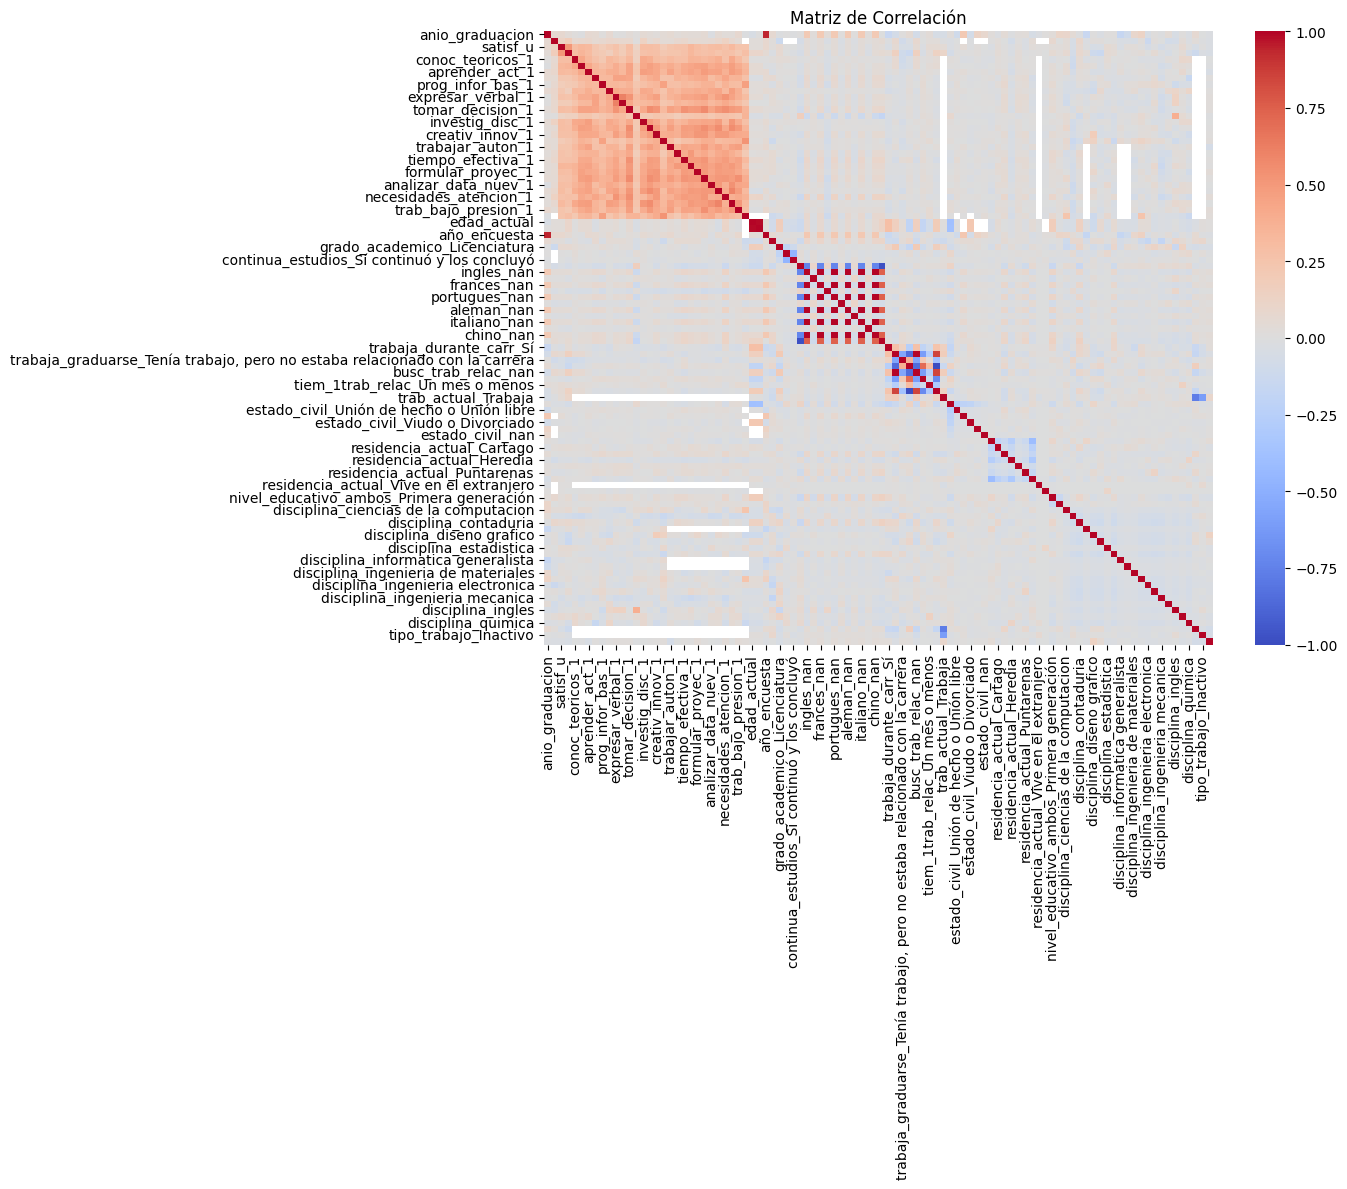

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

# -----------------------------
# 1. Filtrar variables presentes
# -----------------------------
variables_seleccionadas = [
    "anio_graduacion", "sexo", "grado_academico", "continua_estudios", "relacion_estudios", 
    "ingles", "frances", "portugues", "aleman", "italiano", "chino", "solo_espanol", 
    "satisf_u", "satisf_carrera", "trabaja_durante_carr", "trabaja_graduarse", "busc_trab_relac", 
    "tiem_1trab_relac", "trab_actual", "conoc_teoricos_1", "conoc_practicos_1", "aprender_act_1", 
    "trabajo_equipo_1", "prog_infor_bas_1", "redact_doc_inf_1", "expresar_verbal_1", 
    "hablar_publico_1", "tomar_decision_1", "manejo_ingles_1", "investig_disc_1", "resolver_prob_1",
    "creativ_innov_1", "software_espe_1", "trabajar_auton_1", "etico_honestid_1", "tiempo_efectiva_1", 
    "compro_calidad_1", "formular_proyec_1", "adaptarse_sit_nuev_1", "analizar_data_nuev_1", 
    "pensamiento_critic_1", "necesidades_atencion_1", "analisis_sintesis_1", "trab_bajo_presion_1",
    "bases_progama_1", "estado_civil", "residencia_actual", "edad_actual", "edad_graduacion", 
    "nivel_educativo_ambos", "disciplina", "tipo_trabajo", "año_encuesta",
]

variables_presentes = [v for v in variables_seleccionadas if v in df_modelo.columns]
df_analisis = df_modelo[variables_seleccionadas].dropna(how='all').copy()

# -----------------------------
# 2. Codificar variables categóricas
# -----------------------------
cat_vars = df_analisis.select_dtypes(include=["object", "category"]).columns.tolist()
num_vars = [v for v in df_analisis.columns if v not in cat_vars]

# One-hot encoding
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
X_cat = encoder.fit_transform(df_analisis[cat_vars])
X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(cat_vars), index=df_analisis.index)

# Concatenar numéricas y categóricas
X = pd.concat([df_analisis[num_vars], X_cat_df], axis=1)

# -----------------------------
# 3. Matriz de correlación
# -----------------------------
plt.figure(figsize=(14, 12))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

In [61]:
# Encontrar columnas con correlación alta
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.85)]

print(f"🔻 Variables con alta correlación eliminadas: {len(to_drop_corr)}")
print("👉 Variables eliminadas por correlación:")
print(to_drop_corr)

X_filtered = X.drop(columns=to_drop_corr)


🔻 Variables con alta correlación eliminadas: 10
👉 Variables eliminadas por correlación:
['edad_graduacion', 'año_encuesta', 'frances_nan', 'portugues_nan', 'aleman_nan', 'italiano_nan', 'chino_nan', 'solo_espanol_Sí', 'busc_trab_relac_nan', 'tiem_1trab_relac_nan']


In [62]:
# 1. Lista original de variables
variables_seleccionadas = [
    "anio_graduacion", "sexo", "grado_academico", "continua_estudios", "relacion_estudios", 
    "ingles", "frances", "portugues", "aleman", "italiano", "chino", "solo_espanol", 
    "satisf_u", "satisf_carrera", "trabaja_durante_carr", "trabaja_graduarse", "busc_trab_relac", 
    "tiem_1trab_relac", "trab_actual", "conoc_teoricos_1", "conoc_practicos_1", "aprender_act_1", 
    "trabajo_equipo_1", "prog_infor_bas_1", "redact_doc_inf_1", "expresar_verbal_1", 
    "hablar_publico_1", "tomar_decision_1", "manejo_ingles_1", "investig_disc_1", "resolver_prob_1",
    "creativ_innov_1", "software_espe_1", "trabajar_auton_1", "etico_honestid_1", "tiempo_efectiva_1", 
    "compro_calidad_1", "formular_proyec_1", "adaptarse_sit_nuev_1", "analizar_data_nuev_1", 
    "pensamiento_critic_1", "necesidades_atencion_1", "analisis_sintesis_1", "trab_bajo_presion_1",
    "bases_progama_1", "estado_civil", "residencia_actual", "edad_actual", "edad_graduacion", 
    "nivel_educativo_ambos", "disciplina", "tipo_trabajo", "año_encuesta"
]

# 2. Variables identificadas con alta correlación
variables_correlacion_alta = [
    "edad_graduacion", "año_encuesta", "frances_nan", "portugues_nan", "aleman_nan", 
    "italiano_nan", "chino_nan", "solo_espanol_Sí", "busc_trab_relac_nan", "tiem_1trab_relac_nan"
]

# 3. Filtrar para dejar solo las no correlacionadas
variables_filtradas = [v for v in variables_seleccionadas if v not in variables_correlacion_alta]

print("✅ Variables finales seleccionadas para el modelo:")
print(variables_filtradas)


✅ Variables finales seleccionadas para el modelo:
['anio_graduacion', 'sexo', 'grado_academico', 'continua_estudios', 'relacion_estudios', 'ingles', 'frances', 'portugues', 'aleman', 'italiano', 'chino', 'solo_espanol', 'satisf_u', 'satisf_carrera', 'trabaja_durante_carr', 'trabaja_graduarse', 'busc_trab_relac', 'tiem_1trab_relac', 'trab_actual', 'conoc_teoricos_1', 'conoc_practicos_1', 'aprender_act_1', 'trabajo_equipo_1', 'prog_infor_bas_1', 'redact_doc_inf_1', 'expresar_verbal_1', 'hablar_publico_1', 'tomar_decision_1', 'manejo_ingles_1', 'investig_disc_1', 'resolver_prob_1', 'creativ_innov_1', 'software_espe_1', 'trabajar_auton_1', 'etico_honestid_1', 'tiempo_efectiva_1', 'compro_calidad_1', 'formular_proyec_1', 'adaptarse_sit_nuev_1', 'analizar_data_nuev_1', 'pensamiento_critic_1', 'necesidades_atencion_1', 'analisis_sintesis_1', 'trab_bajo_presion_1', 'bases_progama_1', 'estado_civil', 'residencia_actual', 'edad_actual', 'nivel_educativo_ambos', 'disciplina', 'tipo_trabajo']


In [67]:
# -----------------------------
# 8. Selección de variables
# -----------------------------

# Variables seleccionadas según tu lista, excluyendo las eliminadas por correlación
variables_modelo = [
    "anio_graduacion", "sexo", "grado_academico", "continua_estudios", "relacion_estudios", 
    "ingles", "solo_espanol","satisf_u", "satisf_carrera", "trabaja_durante_carr", "trabaja_graduarse", "busc_trab_relac", 
    "tiem_1trab_relac", "conoc_teoricos_1", "conoc_practicos_1", "aprender_act_1", 
    "trabajo_equipo_1", "prog_infor_bas_1", "redact_doc_inf_1", "expresar_verbal_1", 
    "hablar_publico_1", "tomar_decision_1", "manejo_ingles_1", "investig_disc_1", "resolver_prob_1",
    "creativ_innov_1", "software_espe_1", "trabajar_auton_1", "etico_honestid_1", "tiempo_efectiva_1", 
    "compro_calidad_1", "formular_proyec_1", "adaptarse_sit_nuev_1", "analizar_data_nuev_1", 
    "pensamiento_critic_1", "necesidades_atencion_1", "analisis_sintesis_1", "trab_bajo_presion_1",
    "bases_progama_1", "estado_civil", "residencia_actual", "edad_actual", 
    "nivel_educativo_ambos", "disciplina", 
]

# Construir X e y
X = df_modelo[variables_modelo].copy()
y = df_modelo["empleado"].astype(int)

# Confirmar dimensiones
print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)



✅ X shape: (7048, 44)
✅ y shape: (7048,)


## Preprocesamiento

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# -----------------------------
# 9. Preprocesamiento
# -----------------------------

# Identificar variables categóricas y numéricas en X
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Transformador para variables numéricas
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Transformador para variables categóricas
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocesador unificado
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# -----------------------------
# 10. Entrenamiento y evaluación
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

modelo = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))
])

modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:, 1]

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("🎯 ROC AUC:", roc_auc_score(y_test, y_prob))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.91      0.56       159
           1       0.99      0.89      0.94      1956

    accuracy                           0.89      2115
   macro avg       0.70      0.90      0.75      2115
weighted avg       0.95      0.89      0.91      2115

🎯 ROC AUC: 0.9516694319044128


## Coeficientes interpretables

In [70]:
# -----------------------------
# 11. Coeficientes interpretables
# -----------------------------
feature_names = modelo.named_steps['preprocessor'].get_feature_names_out()
coef = modelo.named_steps['classifier'].coef_[0]
coef_series = pd.Series(coef, index=feature_names).sort_values(ascending=False)

print("🔍 Variables más influyentes:")
print(coef_series.head(10))

🔍 Variables más influyentes:
cat__tiem_1trab_relac_Un mes o menos                                               1.953305
cat__estado_civil_Viudo o divorciado                                               1.584085
cat__trabaja_graduarse_Tenía trabajo, pero no estaba relacionado con la carrera    1.265876
num__analisis_sintesis_1                                                           1.253409
cat__busc_trab_relac_Sí                                                            1.198587
num__pensamiento_critic_1                                                          1.188490
num__trabajo_equipo_1                                                              1.104834
cat__disciplina_desarrollo de software                                             1.057958
num__manejo_ingles_1                                                               1.037266
cat__sexo_Hombre                                                                   0.923154
dtype: float64


In [71]:
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Asegúrate de tener X e y ya definidos como en tu modelo
# Usa el mismo preprocessor del pipeline
X_transformed = preprocessor.fit_transform(X)

# Agregar constante (intercepto)
X_sm = sm.add_constant(X_transformed)

# Ajustar el modelo con statsmodels
logit_model = sm.Logit(y, X_sm).fit()

# Resumen del modelo
print(logit_model.summary())


         Current function value: 0.134798
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               empleado   No. Observations:                 7048
Model:                          Logit   Df Residuals:                     6969
Method:                           MLE   Df Model:                           78
Date:                Sat, 28 Jun 2025   Pseudo R-squ.:                  0.4942
Time:                        15:44:20   Log-Likelihood:                -950.06
converged:                      False   LL-Null:                       -1878.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8538        nan        nan        nan         nan         nan
x1            -0.8339      0.075    -11.127      0.000      -0.98

C:\Users\ksandi\AppData\Local\anaconda3\envs\TFM\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [75]:
import statsmodels.api as sm
import pandas as pd

# Asegúrate de tener X e y ya definidos y preprocessor creado

# 1. Transformar X
X_transformed = preprocessor.fit_transform(X)

# 2. Obtener nombres de las variables transformadas
feature_names = preprocessor.get_feature_names_out()

# 3. Agregar constante (intercepto)
X_sm = sm.add_constant(X_transformed)

# 4. Ajustar el modelo logit
logit_model = sm.Logit(y, X_sm).fit()

# 5. Crear DataFrame resumen con nombres reales
summary_df = pd.DataFrame({
    "Variable": ["const"] + list(feature_names),
    "Coeficiente": logit_model.params,
    "StdErr": logit_model.bse,
    "z": logit_model.tvalues,
    "p-value": logit_model.pvalues,
    "CI_2.5%": logit_model.conf_int()[0],
    "CI_97.5%": logit_model.conf_int()[1]
})

# 6. Mostrar las variables más significativas
summary_df_ordenado = summary_df.sort_values("p-value")
print("\n📌 Variables ordenadas por significancia estadística (p-value):")
display(summary_df_ordenado.head(20))



         Current function value: 0.134798
         Iterations: 35

📌 Variables ordenadas por significancia estadística (p-value):


C:\Users\ksandi\AppData\Local\anaconda3\envs\TFM\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Variable,Coeficiente,StdErr,z,p-value,CI_2.5%,CI_97.5%
x1,num__anio_graduacion,-0.833923,0.074944,-11.127317,9.237416e-29,-0.980810,-0.687036
x9,num__prog_infor_bas_1,-0.967077,0.099069,-9.761607,1.645276e-22,-1.161249,-0.772904
x17,num__creativ_innov_1,-0.873431,0.105830,-8.253168,1.542500e-16,-1.080853,-0.666008
x8,num__trabajo_equipo_1,0.641215,0.086161,7.442028,9.915117e-14,0.472342,0.810088
x14,num__manejo_ingles_1,0.614224,0.088126,6.969871,3.172328e-12,0.441501,0.786947
x28,num__analisis_sintesis_1,0.747258,0.120688,6.191656,5.953525e-10,0.510714,0.983801
x26,num__pensamiento_critic_1,0.647172,0.111115,5.824329,5.734255e-09,0.429390,0.864954
x6,num__conoc_practicos_1,-0.475457,0.093680,-5.075321,3.868421e-07,-0.659067,-0.291847
x4,num__satisf_carrera,0.305947,0.067604,4.525594,6.022615e-06,0.173446,0.438448
x16,num__resolver_prob_1,0.418055,0.095544,4.375524,1.211413e-05,0.230792,0.605318



📊 Logistic Regression
Accuracy: 0.9199
F1 Score: 0.9583
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       106
           1       0.92      0.99      0.96      1304

    accuracy                           0.92      1410
   macro avg       0.46      0.50      0.48      1410
weighted avg       0.85      0.92      0.89      1410



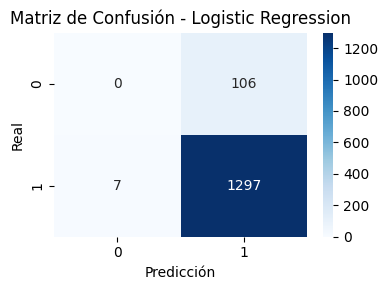


📊 Random Forest
Accuracy: 1.0
F1 Score: 1.0
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00      1304

    accuracy                           1.00      1410
   macro avg       1.00      1.00      1.00      1410
weighted avg       1.00      1.00      1.00      1410



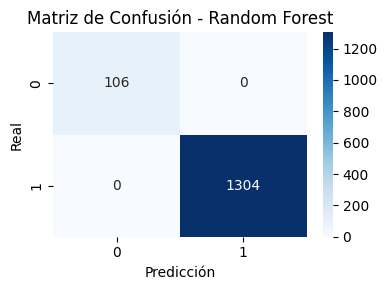


📊 Gradient Boosting
Accuracy: 0.9986
F1 Score: 0.9992
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       106
           1       1.00      1.00      1.00      1304

    accuracy                           1.00      1410
   macro avg       0.99      1.00      0.99      1410
weighted avg       1.00      1.00      1.00      1410



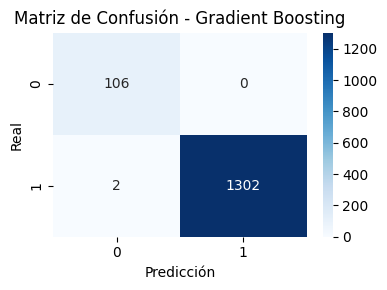


📌 Comparación de modelos:


,Modelo,Accuracy,F1 Score
1,Random Forest,1.000000,1.000000
2,Gradient Boosting,0.998582,0.999233
0,Logistic Regression,0.919858,0.958256


In [89]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Paso 1: Variables significativas (según p-value < 0.05)
variables_significativas = [
    "anio_graduacion", "prog_infor_bas_1", "creativ_innov_1",
    "trabajo_equipo_1", "manejo_ingles_1", "analisis_sintesis_1",
    "pensamiento_critic_1", "conoc_practicos_1", "satisf_carrera",
    "resolver_prob_1", "investig_disc_1", "conoc_teoricos_1",
    "software_espe_1", "hablar_publico_1", "trabajar_auton_1",
    "formular_proyec_1", "expresar_verbal_1", "edad_actual",
    "trab_bajo_presion_1"
]

# Paso 2: Filtrar dataset
X = df[variables_significativas]
y = df["empleado"].astype(int)

# Paso 3: Separar variables categóricas y numéricas
cat_vars = X.select_dtypes(include="object").columns.tolist()
num_vars = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Paso 4: Preprocesador con imputación
preprocesador = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_vars),
    
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_vars)
])

# Paso 5: Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Paso 6: Modelos a evaluar
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Paso 7: Entrenamiento y evaluación
resultados = []

for nombre, modelo in modelos.items():
    pipeline = Pipeline([
        ("preprocesamiento", preprocesador),
        ("modelo", modelo)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n📊 {nombre}")
    print("Accuracy:", round(acc, 4))
    print("F1 Score:", round(f1, 4))
    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    resultados.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "F1 Score": f1
    })

# Paso 8: Mostrar resumen comparativo
df_resultados = pd.DataFrame(resultados).sort_values(by="F1 Score", ascending=False)
print("\n📌 Comparación de modelos:")
display(df_resultados)


In [104]:
import numpy as np
import pandas as pd

# Asegurarse de que el preprocesador está entrenado
preprocessor.fit(X_train)

# Obtener nombres de variables transformadas (numéricas + categóricas codificadas)
feature_names = preprocessor.get_feature_names_out()

# Obtener coeficientes del modelo entrenado
coefs = model.coef_[0]

# Crear DataFrame con coeficientes y odds ratios
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': coefs,
    'Odds Ratio': np.exp(coefs)
}).sort_values(by='Odds Ratio', ascending=False)

# Mostrar todos los resultados ordenados por Odds Ratio
print("\n📌 Tabla completa de variables y sus Odds Ratios:")
display(coef_df)



📌 Tabla completa de variables y sus Odds Ratios:


,Variable,Coeficiente,Odds Ratio
4,num__manejo_ingles_1,1.046538,2.847775
3,num__trabajo_equipo_1,0.971090,2.640821
12,num__software_espe_1,0.871250,2.389896
10,num__investig_disc_1,0.592539,1.808574
11,num__conoc_teoricos_1,0.573669,1.774767
9,num__resolver_prob_1,0.478536,1.613711
6,num__pensamiento_critic_1,0.475805,1.609308
5,num__analisis_sintesis_1,0.457138,1.579546
8,num__satisf_carrera,0.307759,1.360373
14,num__trabajar_auton_1,0.097462,1.102370
